In [1]:
import os
import time
from utils import data_importer
from utils import model as md
from utils import unet, fcrn, metrics

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)
from tensorflow.keras import backend as K

###########  Manual device placement & Limiting GPU memory growth #######
GPU_ID = 1
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[GPU_ID], True) #Sllocate memory as-needed
tf.config.experimental.set_visible_devices(physical_gpus[GPU_ID], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(physical_gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

2 Physical GPUs, 1 Logical GPU


In [368]:
log_address = './log/depth/M18_all_MAPE/' #M0_all_MAPE_NormalizedInput

In [369]:
log_file = pd.read_pickle(log_address + 'visual_log.pkl')#depth_car_v1   baseline  baseline_normalized_input
log_file.columns

Index(['feature_list', 'label_list', 'predict 0', 'predict 1', 'predict 2',
       'predict 3', 'predict 4', 'predict 5', 'predict 6', 'predict 7',
       'predict 8', 'predict 9', 'predict 10', 'predict 11', 'predict 12',
       'predict 13', 'predict 14', 'predict 15', 'predict 16', 'predict 17',
       'predict 18', 'predict 19', 'predict 20', 'predict 21', 'predict 22',
       'predict 23', 'predict 24', 'predict 25', 'predict 26', 'predict 27',
       'predict 28', 'predict 29'],
      dtype='object')

In [370]:
feature_list = log_file['feature_list']
label_list = log_file['label_list']
end_of_epoch_results = [log_file[index] for index in log_file.columns[2:]]

In [371]:
end_of_epoch_results[0][0].shape

(480, 640)

In [399]:
batch_size=3

In [400]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils import visualizer as vis

def f(num_slider, num_play, epoch_slider, epoch_play):
    num_slider -=1
    epoch_slider -=1
    fig11 = plt.figure(figsize=(64//2, 48//2), constrained_layout=False)

    # gridspec inside gridspec
    outer_grid = fig11.add_gridspec(4, 1, wspace=0.0, hspace=0.0)
    data = [feature_list[0][0][num_slider],
            label_list[0][0][num_slider,:,:,0],
            end_of_epoch_results[epoch_slider][num_slider]]
    titles = ["RGB Feature",
              "Depth Label",
              "Depth Estimation"]
    
    inner_grid = outer_grid[0].subgridspec(1, 4, wspace=0.0, hspace=0.0)
    
    for j in range(1, 4):
        ax = fig11.add_subplot(inner_grid[j])
        ax.imshow(data[j-1])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(titles[j-1], {'fontsize':20})
        fig11.add_subplot(ax)
        

plt.set_cmap('prism')
# plt.set_cmap('rainbow')
    

num_slider = widgets.IntSlider(description="Sample Num", min=1, max=batch_size, continuous_update=False)
num_play = widgets.Play(interval=1500,  min=1,    max=batch_size,    step=1,    description="Sample Num",    disabled=False)
widgets.jslink((num_slider, 'value'), (num_play, 'value'))

epoch_slider = widgets.IntSlider(description="Epoch Num", min=1, max=len(log_file.columns)-2, continuous_update=False)
epoch_play = widgets.Play(interval=1500,  min=1, max=len(log_file.columns),    step=1,    description="Epoch Num",    disabled=False)
widgets.jslink((epoch_slider, 'value'), (epoch_play, 'value'))

interact(f, 
         num_slider=num_slider,
         num_play=num_play,
         epoch_slider=epoch_slider,
         epoch_play=epoch_play)

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=1, continuous_update=False, description='Sample Num', max=3, min=1), Pla…

<function __main__.f(num_slider, num_play, epoch_slider, epoch_play)>

In [420]:
log_dir = './log/depth/'
dirs = os.listdir(log_dir)

In [511]:
COMPARISON_TABEL = []

metric_log = pd.read_pickle('./log/depth/M0_all_MAPE/metric_log.pkl')
common_label = metric_log.columns[-9:] 
c= []
for i,_ in enumerate(common_label):
     c.append(common_label[i].replace('val_', ""))


for d in dirs:
    log_address = log_dir + d
    metric_log = pd.read_pickle(log_address + '/metric_log.pkl')
           
    a = metric_log.iloc[-1][-9:]
    
#     for i, _ in enumerate(a):
#         a[-1-i] = metric_log.iloc[:,-1-i].min() or .max()
    
    a.set_axis(c, inplace=True)
    a.name = d
    COMPARISON_TABEL.append(a)
x = pd.DataFrame(COMPARISON_TABEL)

In [422]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    if 'delta_threshold' in s.name:
        d = s == s.max()
    else:
        d = s == s.min()
    return ['background-color: yellow' if v else '' for v in d]

In [423]:
x.style.apply(highlight_max)

,MAPE,MSPE,RMSE,RMSELog,Log10,delta_threshold_1,delta_threshold_2,delta_threshold_3,SILog
M0_all_MAPE,3.79266,494.335,61.6502,0.249318,0.0500632,0.976337,0.985596,0.990071,0.066829
M10_all_MAPE,4.22326,528.527,61.3868,0.252821,0.0532708,0.967874,0.983322,0.98952,0.0690207
M11_all_MAPE,3.5216,563.581,65.2074,0.278862,0.0500844,0.974533,0.984514,0.988477,0.0985206
M12_all_MAPE,7.26282,627.632,65.2961,0.28597,0.0748875,0.932063,0.967633,0.980323,0.0836668
M13_all_MAPE,4.44593,608.178,66.8174,0.267107,0.0574408,0.974994,0.984887,0.988608,0.0723597
M14_all_MAPE,5.25179,864.83,87.259,0.328014,0.0743975,0.961204,0.977399,0.983553,0.10896
M15_all_MAPE,23.7696,15558.6,392.264,1.10933,0.53386,0.756824,0.789997,0.799119,1.02658
M16_all_MAPE,30.8346,17726.3,418.028,2.29113,1.05774,0.600577,0.700761,0.749537,4.25386
M17_all_MAPE,8.24908,1083.75,97.1105,0.362637,0.107484,0.929095,0.96755,0.977429,0.131835
M18_all_MAPE,36.9997,18394.1,422.491,2.282,1.15505,0.541275,0.686307,0.746097,4.26675


In [472]:
log_dir = './log/depth/'
dirs = os.listdir(log_dir)

dirs_num = [int(d.replace('_all_MAPE', '').replace('M','')) for d in dirs]

log_list = []
for num in range(max(dirs_num)+1):
    folder = 'M' + str(num) + '_all_MAPE'
    log_address = log_dir + folder
    metric_log = pd.read_pickle(log_address + '/metric_log.pkl')
    metric_log['Model'] =  ['M' + str(num) for _ in  range(metric_log.index.size)]
    log_list.append(metric_log)
    
conc = pd.concat(log_list) 

C:\Users\KINEMATIX\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [515]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils import visualizer as vis

def plotter(y):
    fig = px.line(conc, x='epoch', y=y, color='Model', log_y=True) 
    fig.show()
    
metric_list = ['val_MAPE', 'val_MSPE', 'val_RMSE', 'val_RMSELog', 'val_Log10',
       'val_delta_threshold_1', 'val_delta_threshold_2',
       'val_delta_threshold_3', 'val_SILog']
metric_type = widgets.Dropdown(
    options=metric_list,
    value=metric_list[0],
    description='Metric Type:',
    disabled=False,
    )
# widgets.jslink((metric_type, 'metric_type'))

interact(plotter, 
         y=metric_type)


interactive(children=(Dropdown(description='Metric Type:', options=('val_MAPE', 'val_MSPE', 'val_RMSE', 'val_R…

<function __main__.plotter(y)>

## Plot

In [ ]:
dsg_validation.index= 59
preview = iter(dsg_validation)
feature_list, label_list=next(preview)
model.evaluate(feature_list, label_list)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils import visualizer as vis

options=['Simple plot', 'RGB point cloud', 'Segmented point cloud']

def f(x):
    vis.draw_samples(feature_list, label_list, x-1,
                     feature_types=COMMON_SETTING['feature_types'], 
                     label_types=COMMON_SETTING['label_types'])
    
def f2(x):
    vis.draw_point_cloud(label_list[0][x-1], feature_list[0][x-1])
    
def view_type_selector(y):
    if y == options[0]:
        interact(f, 
                 x=widgets.IntSlider(description="Sample Num", min=1, max=dsg_train.batch_size, continuous_update=False))
    if y == options[1]:
        interact_manual(f2,
                        x=widgets.IntSlider(description="Sample Num", min=1, max=dsg_train.batch_size, continuous_update=False))
    else:
        print(y)
        
x=interact_manual(view_type_selector, y=widgets.Dropdown(description="View type:", options=options))

In [ ]:
i = 4
plt.figure(figsize=(20,20))
plt.set_cmap('hot')
plt.subplot(1,3,1)
plt.imshow(label_list[0][0, :, :, 0])
plt.subplot(1,3,2)
plt.imshow(predict[0, :, :, 0])
plt.subplot(1,3,3)
plt.imshow((label_list[0][0, :, :, 0]-predict[0, :, :, 0])/(label_list[0][0, :, :, 0]+0.0000001))


In [ ]:
(label_list[0][0, :, :, 0]-predict[0, :, :, 0]).sum()

In [ ]:
vis.draw_point_cloud(predict[0, :, :, 0], feature_list[0][0])

In [ ]:
vis.draw_point_cloud(predict[0, :, :, 0], feature_list[0][0])

In [ ]:
vis.draw_point_cloud(label_list[0][0, :, :, 0], feature_list[0][0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

In [ ]:
image =  feature_list[0][0]
depth = predict[0, :, :, 0]*100

In [ ]:
a = o3d.geometry.Image(image)  #pylint: disable=no-member
b = o3d.geometry.Image(depth)  #pylint: disable=no-member
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(a, b)  #pylint: disable=no-member
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(  #pylint: disable=no-member
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(  #pylint: disable=no-member
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))  #pylint: disable=no-member

# rgb_vector = np.reshape(image, [-1, 3])
# pcd.colors = o3d.utility.Vector3dVector(rgb_vector)  #pylint: disable=no-member
o3d.visualization.draw_geometries([pcd])  #pylint: disable=no-member

# Plotly

In [ ]:
import pandas as pd
import plotly.express as px

In [ ]:
import plotly

In [ ]:
deptmap = label_list[0][0][:,:,0]

In [ ]:
x_l = []
y_l = []
z_l = []
c_l = []
s_l = []
for x in range(deptmap.shape[0]):
    for y in range(deptmap.shape[1]):
        x_l.append(x)
        y_l.append(y)
        z_l.append(deptmap[x,y]*1000)
        c_l.append(deptmap[x,y]*1000)
        s_l.append(0.1)
df = pd.DataFrame({'x':x_l, 'y':y_l, 'z':z_l,  'color':c_l, 'size':s_l})

In [ ]:
fig = px.scatter(df, x='y', y='x',color='color', size='size', hover_name='color',  render_mode='webgl')

In [ ]:
# iris = px.data.iris()
fig = px.scatter_3d(df, x='x', y='y', z='z', color='color', size='size')
# fig = px.scatter(df, x='y', y='x',color='color', size='size', hover_name='color',  render_mode='webgl')
fig.data[0].marker.line.width=0
fig.data[0].marker.size = 1
fig.layout.yaxis.autorange='reversed'
fig.show()

In [ ]:
plotly.io.write_html(fig, file="m.html")

# Dataset And Model' Output Histogram

In [22]:
COMMON_SETTING = {
    'table_address' : "./utils/labels.csv",
    'batch_size' : 1, 
    'output_shape' : (480, 640),
    'data_type' : 'float32',
    'feature_types' : ['image', 'segmentation' ],
    'label_types' : ['depth'],# ['depth'], #'semantic_depth'
    'class_ids' : 'all'#[55,]#data_importer.COMMON_LABEL_IDS.copy()#
}

############################ SYNTHIA_SF_SETTINGS ########################################
address = 'C:/Users/KINEMATIX/Amin/Datasets/SYNTHIA-SF'#'D:/Library/Datasets/SYNTHIA-SF'#
dsg = data_importer.SynthiaSf
usage_range_train = (0, 1)
usage_range_validation = (0.75, 1)
usage_range_test = (0.75, 1)

dsg_train = dsg(**COMMON_SETTING,
                dataset_dir=address,
                usage='train',
                usage_range=usage_range_train)

dsg_validation = dsg(**COMMON_SETTING,
                    dataset_dir=address,
                    usage='validation',
                    usage_range=usage_range_validation)

C:\Users\KINEMATIX\.conda\envs\tf\lib\site-packages\pandas\core\ops\__init__.py:1069: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [345]:
dsg_train.index = dsg_train.start_index
preview = iter(dsg_train)
size = int(dsg_train.size/dsg_train.batch_size)

try:
    del(train_set_hist)
except NameError:
    pass

nn_mean = 0
n_mean  = 0

for i in range(size):
    feature_list, label_list=next(preview)
    depth_data = label_list[0][0, :, :, 0]
    hist = np.histogram(depth_data, np.arange(0,1050,50))[0]
    try:
        train_set_hist = hist + train_set_hist
    except NameError:
        train_set_hist = hist
        
    nn_mean_error +=  abs(result[0, :, :, 0] - depth_data).mean()/size
    n_mean_error  += abs(result[0, :, :, 0] - depth_data/1000).mean()/size
    print(i/size*100)
        
train_set_hist_bins = np.histogram(depth_data, 20)[1]

0.0
0.022487069934787496
0.04497413986957499
0.06746120980436249
0.08994827973914998
0.11243534967393749
0.13492241960872497
0.15740948954351247
0.17989655947829997
0.2023836294130875
0.22487069934787499
0.24735776928266248
0.26984483921744995
0.29233190915223745
0.31481897908702494
0.33730604902181244
0.35979311895659993
0.3822801888913875
0.404767258826175
0.4272543287609625
0.44974139869574997
0.47222846863053747
0.49471553856532496
0.5172026085001125
0.5396896784348999
0.5621767483696873
0.5846638183044749
0.6071508882392624
0.6296379581740499
0.6521250281088374
0.6746120980436249
0.6970991679784124
0.7195862379131999
0.7420733078479874
0.764560377782775
0.7870474477175624
0.80953451765235
0.8320215875871374
0.854508657521925
0.8769957274567124
0.8994827973914999
0.9219698673262875
0.9444569372610749
0.9669440071958625
0.9894310771306499
1.0119181470654375
1.034405217000225
1.0568922869350124
1.0793793568697998
1.1018664268045872
1.1243534967393747
1.1468405666741623
1.169327636608

In [165]:
num_of_classes = dsg_train.class_ids.size
model = fcrn.model(img_shape=(480,640,3))
model.compile(optimizer="adam", loss=metrics.MAPE())

In [346]:
preview = iter(dsg_train)
feature_list, label_list=next(preview)
result = model.predict(feature_list)

#### Normalized

In [377]:
predict_hist = np.histogram(result, bins=np.arange(0,3,0.05))

In [378]:
depth_label = ['  Depth Labels' for _ in range(59)]
d = np.append(train_set_hist, np.zeros(39))
data1 = pd.DataFrame({'depth': predict_hist[1][1:], 'percent': d*100/d.sum(), 'label': depth_label})

depth_label = ['  Prediction' for _ in range(59)]
data2 = pd.DataFrame({'depth': predict_hist[1][1:], 'percent': predict_hist[0]*100/predict_hist[0].sum(), 'label': depth_label})

a = data2.append(data1)
a.index = np.arange(118)

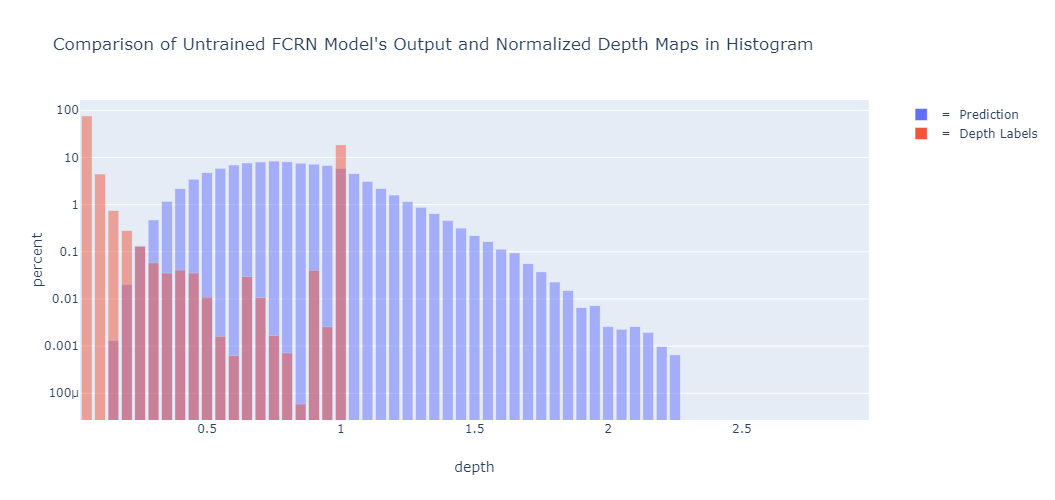

In [379]:
fig = px.bar(a, x='depth', y='percent',  log_y=True, height=500, width=800,  color='label',barmode='overlay', labels={'label':""}, 
       title="Comparison of Untrained FCRN Model's Output and Normalized Depth Maps in Histogram")
fig.write_html("Comparison of Untrained FCRN Model's Output and Normalized Depth Maps in Histogram.html")
fig

In [350]:
predict_mean = (predict_hist[0]*predict_hist[1][1:]).sum()/predict_hist[0].sum()

In [352]:
depth_maps_mean = (d*predict_hist[1][1:]).sum()/d.sum()

In [353]:
abs(predict_mean - depth_maps_mean) / n_mean_error

0.38681656085320665

In [362]:
n_mean_error

1.4624971282034438

#### Non-normalized

In [374]:
predict_hist = np.histogram(result, bins=train_set_hist_bins)

In [375]:
depth_label = ['  Depth Labels' for _ in range(20)]
data1 = pd.DataFrame({'depth': train_set_hist_bins[1:], 'percent': train_set_hist*100/train_set_hist.sum(), 'label': depth_label})

depth_label = ['  Prediction' for _ in range(20)]
data2 = pd.DataFrame({'depth': train_set_hist_bins[1:], 'percent': predict_hist[0]*100/predict_hist[0].sum(), 'label': depth_label})

a = data2.append(data1)
a.index = np.arange(40)

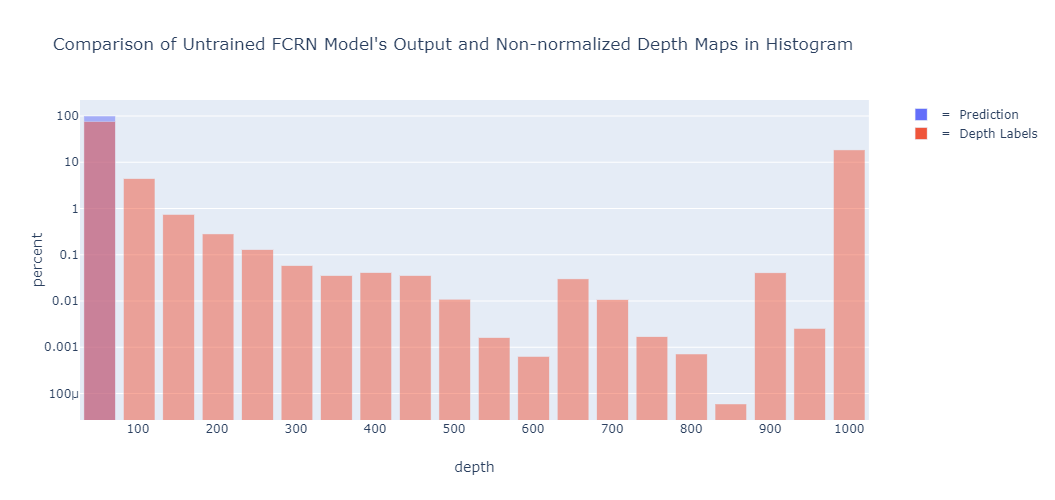

In [376]:
fig = px.bar(a, x='depth', y='percent',  log_y=True, height=500, width=800,  color='label',barmode='overlay', labels={'label':""}, 
       title="Comparison of Untrained FCRN Model's Output and Non-normalized Depth Maps in Histogram")
fig.write_html("Comparison of Untrained FCRN Model's Output and Non-normalized Depth Maps in Histogram.html")
fig

In [357]:
predict_mean = (predict_hist[0]*predict_hist[1][1:]).sum()/predict_hist[0].sum()

In [359]:
depth_maps_mean = (train_set_hist*predict_hist[1][1:]).sum()/train_set_hist.sum()

In [360]:
abs(predict_mean - depth_maps_mean) / nn_mean_error

0.42206342858502977

In [361]:
nn_mean_error

426.04598936574706